In [123]:
# import all required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

scoring = 'neg_mean_squared_error'
seed = 7

In [124]:
# Cross validation framework
def do_cross_validation(X, y, scoring = 'neg_mean_squared_error'):
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('LASSO', Lasso()))
    models.append(('EN', ElasticNet()))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('CART', DecisionTreeRegressor()))
    models.append(('Ridge', Ridge()))
    #models.append(('SVR', SVR()))
    results_rmse = []
    results_r2 = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=7)
        cv_results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring))
        cv_results_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        results_rmse.append(cv_results)
        results_r2.append(cv_results_r2)
        names.append(name)
        msg = "%s: %f (%f) r2: %f (%f)" % \
        (name, cv_results.mean(), cv_results.std(), cv_results_r2.mean(), cv_results_r2.std())
        print(msg)
    return results_rmse, results_r2, names

In [146]:
pisaTrain = pd.read_csv('pisa2009train.csv')
pisaTest = pd.read_csv('pisa2009test.csv')
print('Shape of training set: ',pisaTrain.shape)
print('Shape of test set: ', pisaTest.shape)

('Shape of training set: ', (3663, 24))
('Shape of test set: ', (1570, 24))


### Impute Missing Values

In [148]:
print('Missing values in Training set:', pisaTrain.isnull().sum().sum())
print('Missing values in Test set:', pisaTest.isnull().sum().sum())

('Missing values in Training set:', 2950L)
('Missing values in Test set:', 1379L)


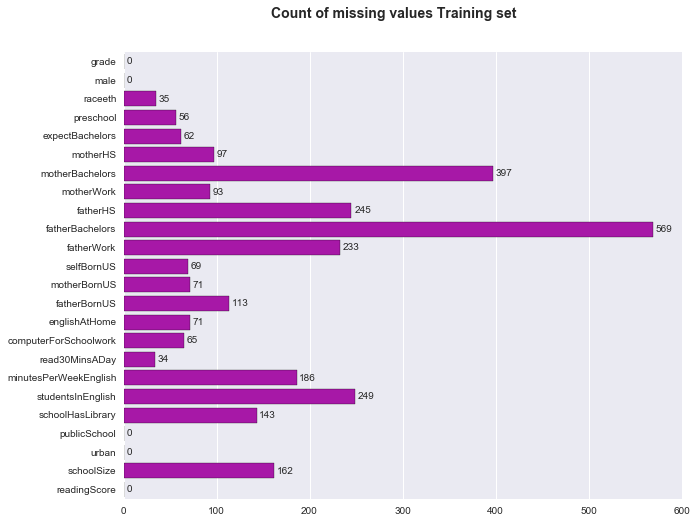

In [149]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Count of missing values Training set', fontsize=14, fontweight='bold')
null_data = pisaTrain.isnull().sum()
ax = sns.barplot(x = null_data.values, y=null_data.index, color="m" )
i = 0
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3, p.get_y() + 0.5, null_data.values[i])
    i += 1

In [127]:
# For continuous variables replace the missing data with average of columns
pisaTrain['minutesPerWeekEnglish'].fillna(int(pisaTrain['minutesPerWeekEnglish'].mean()), inplace=True)
pisaTrain['studentsInEnglish'].fillna(int(pisaTrain['studentsInEnglish'].mean()), inplace=True)
pisaTrain['schoolSize'].fillna(int(pisaTrain['schoolSize'].mean()), inplace=True)

# For 'raceeth' use 'missing' replacement
pisaTrain['raceeth'].fillna('NoRace', inplace=True)
# For binary variable use 0.5 in place of missing value

pisaTrain = pisaTrain.apply(lambda x:x.fillna(0.5))

### Encode categorical values

In [128]:
raceeth = pd.get_dummies(pisaTrain['raceeth'], 'raceeth')
pisaTrain = pd.concat([pisaTrain, raceeth], axis=1)
pisaTrain = pisaTrain.drop('raceeth', axis=1)

### Evaluate Algorithms: Baseline

In [129]:
y_train = pisaTrain['readingScore'].values
pisaTrain = pisaTrain.drop('readingScore', axis=1)

In [130]:
X_train = pisaTrain.values
rmse, r2, names = do_cross_validation(X_train, y_train)

LR: 76.233163 (2.007509) r2: 0.359639 (0.040587)
LASSO: 77.037737 (1.520919) r2: 0.346413 (0.031672)
EN: 84.186997 (1.511509) r2: 0.220153 (0.016530)
KNN: 92.449418 (2.142551) r2: 0.059488 (0.030441)
CART: 107.224535 (1.994411) r2: -0.266851 (0.110064)
Ridge: 76.229345 (1.999130) r2: 0.359707 (0.040469)


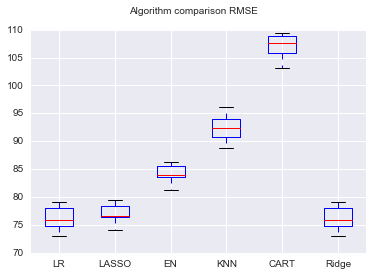

In [131]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm comparison RMSE')
ax = fig.add_subplot(111)
plt.boxplot(rmse)
ax.set_xticklabels(names)
plt.show()

## Data Preparation and Modeling Pipeline

In [132]:
# remove multicolinearity
pisaTrain = pisaTrain.drop(['motherBachelors','motherBornUS', 'fatherBornUS'], axis=1)

In [133]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [134]:
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX = scaler.fit_transform(X_train)
_ = do_cross_validation(rescaledX, y_train)


LR: 76.233163 (2.007509) r2: 0.359639 (0.040587)
LASSO: 77.037737 (1.520919) r2: 0.346413 (0.031672)
EN: 84.186997 (1.511509) r2: 0.220153 (0.016530)
KNN: 92.449418 (2.142551) r2: 0.059488 (0.030441)
CART: 106.553735 (2.550560) r2: -0.242519 (0.083073)
Ridge: 76.229345 (1.999130) r2: 0.359707 (0.040469)


In [135]:
scaler = StandardScaler()
rescaledX = scaler.fit_transform(X_train)
_ = do_cross_validation(rescaledX, y_train)

LR: 76.233163 (2.007509) r2: 0.359639 (0.040587)
LASSO: 77.037737 (1.520919) r2: 0.346413 (0.031672)
EN: 84.186997 (1.511509) r2: 0.220153 (0.016530)
KNN: 92.449418 (2.142551) r2: 0.059488 (0.030441)
CART: 106.294389 (2.856093) r2: -0.265162 (0.091381)
Ridge: 76.229345 (1.999130) r2: 0.359707 (0.040469)


In [136]:
scaler = Normalizer()
rescaledX = scaler.fit_transform(X_train)
_ = do_cross_validation(rescaledX, y_train)

LR: 76.233163 (2.007509) r2: 0.359639 (0.040587)
LASSO: 77.037737 (1.520919) r2: 0.346413 (0.031672)
EN: 84.186997 (1.511509) r2: 0.220153 (0.016530)
KNN: 92.449418 (2.142551) r2: 0.059488 (0.030441)
CART: 107.110093 (3.134743) r2: -0.268529 (0.094255)
Ridge: 76.229345 (1.999130) r2: 0.359707 (0.040469)


In [137]:
# create pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('LR', LinearRegression()))
model = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=7)
results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
print(results.mean())

76.2263128012


## Feature Selection

### Multicollinearity

In [138]:
# correlation
df = pisaTrain
df['readingScore']=y_train
corDf = df.corr(method='pearson')
corDf

,grade,male,preschool,expectBachelors,motherHS,motherWork,fatherHS,fatherBachelors,fatherWork,selfBornUS,...,schoolSize,raceeth_American Indian/Alaska Native,raceeth_Asian,raceeth_Black,raceeth_Hispanic,raceeth_More than one race,raceeth_Native Hawaiian/Other Pacific Islander,raceeth_NoRace,raceeth_White,readingScore
grade,1.000000,-0.097677,-0.021766,0.140540,0.010257,0.020625,0.053409,0.047561,0.022629,-0.012853,...,0.065153,-0.016368,0.089396,-0.045089,-0.006938,-0.003097,0.033419,-0.020978,0.002988,0.286752
male,-0.097677,1.000000,0.014562,-0.076404,0.024292,-0.012175,0.015586,0.070289,0.028771,0.021990,...,0.012632,0.027805,-0.019966,-0.016581,0.020550,-0.001120,0.036709,-0.010593,-0.008540,-0.153928
preschool,-0.021766,0.014562,1.000000,0.078369,0.140993,0.068907,0.113146,0.130973,0.070517,0.103085,...,-0.031264,-0.016049,-0.005916,0.037790,-0.123527,-0.015943,0.004687,-0.032647,0.096177,0.045187
expectBachelors,0.140540,-0.076404,0.078369,1.000000,0.119137,0.074113,0.169416,0.168477,0.020141,0.003550,...,0.016632,-0.026066,0.059741,-0.011855,-0.088315,-0.004993,-0.005201,-0.046981,0.076159,0.361622
motherHS,0.010257,0.024292,0.140993,0.119137,1.000000,0.174679,0.485297,0.201618,0.050979,0.187291,...,-0.080949,-0.014109,-0.066491,0.064726,-0.336096,0.028352,0.009428,-0.068325,0.270878,0.173794
motherWork,0.020625,-0.012175,0.068907,0.074113,0.174679,1.000000,0.098969,0.054351,0.039360,0.068667,...,-0.035975,-0.024675,-0.034391,0.049792,-0.093844,0.009197,-0.010786,-0.041674,0.071577,0.051478
fatherHS,0.053409,0.015586,0.113146,0.169416,0.485297,0.098969,1.000000,0.244917,0.140067,0.147575,...,-0.079518,-0.011025,0.006324,0.024422,-0.315680,0.019232,0.030921,-0.066455,0.250133,0.201740
fatherBachelors,0.047561,0.070289,0.130973,0.168477,0.201618,0.054351,0.244917,1.000000,0.085162,-0.002334,...,0.019117,-0.039026,0.049343,-0.048746,-0.190080,-0.023822,-0.021133,0.031903,0.187147,0.216128
fatherWork,0.022629,0.028771,0.070517,0.020141,0.050979,0.039360,0.140067,0.085162,1.000000,0.006200,...,-0.022964,-0.032708,-0.011077,-0.104864,-0.032662,-0.023480,-0.044278,-0.060143,0.135663,0.100779
selfBornUS,-0.012853,0.021990,0.103085,0.003550,0.187291,0.068667,0.147575,-0.002334,0.006200,1.000000,...,-0.113936,0.030164,-0.199957,0.028020,-0.188224,0.029500,-0.018732,-0.106972,0.225705,0.045038


In [139]:
indices = np.where(corDf > 0.5)
indices = [(corDf.index[x], corDf.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

In [140]:
#remove 'motherBachelors','motherBornUS', 'fatherBornUS'


## Feature Extraction and Modeling Pipeline

In [141]:


# create feature union
features = []
features.append(('pca', PCA(n_components=5)))
features.append(('select_best', SelectKBest(score_func=f_regression, k=4)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('LR', LinearRegression()))

model = Pipeline(estimators)

# evaluate pipeline
kfold = KFold(n_splits=10, random_state=7)
results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold,  scoring = 'neg_mean_squared_error'))
print(results.mean())



78.3169436047


## Ensemble

In [142]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: 78.396744 (1.219982)
ScaledGBM: 73.645606 (1.790392)
ScaledRF: 80.581046 (2.277024)
ScaledET: 86.595193 (2.154823)


In [143]:
ensembles = []
ensembles.append(('ScaledAB', AdaBoostRegressor()))
ensembles.append(('ScaledGBM', GradientBoostingRegressor()))
ensembles.append(('ScaledRF', RandomForestRegressor()))
ensembles.append(('ScaledET', ExtraTreesRegressor()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: 78.748124 (1.360274)
ScaledGBM: 73.645618 (1.796602)
ScaledRF: 81.299289 (2.183773)
ScaledET: 86.978062 (2.134688)


In [144]:
from sklearn.model_selection import GridSearchCV
model = Ridge()
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), scoring=scoring)
grid_result = grid.fit(X_train, y_train)


In [145]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (np.sqrt(-mean), np.sqrt(stdev), param))

Best: -5805.930810 using {'alpha': 1.0}
76.196659 (5.427185) with: {'alpha': 1.0}
76.200718 (5.500046) with: {'alpha': 0.10000000000000001}
76.201161 (5.507399) with: {'alpha': 0.01}
76.201206 (5.508135) with: {'alpha': 0.001}
76.201210 (5.508209) with: {'alpha': 0.0001}
76.215471 (5.231061) with: {'alpha': 0.0}
